# Dust Extinction in IC 5146

It is well established that dust particles in the interstellar medium (ISM) absorb and scatter light from celestial objects in a highly selective manner, particularly affecting the UV wavelengths. Dust extinction is defined as $A_\lambda = 2.5 \log_{10}(F_{0,\lambda}/F_\lambda)$, where $F_{0,\lambda}$ and $F_\lambda$ are the intrinsic and observed fluxes. The optical depth is simply $\tau_\lambda = A_{\lambda}/1.086$.

Extinction is often expressed as function of the color excess (or reddening) $E(B-V) = (B-V)_{\text{observed}} - (B-V)_{\text{intrinsic}}$ and of the extinction curve $k(\lambda)$:

$$A_\lambda = k(\lambda)\,E(B-V)$$

Reddening is a measure of the column density of dust, while the extinction curve speaks of microphyisics of dust absorption. This last is often parametrized by the total-to-selective extinction ratio $R_V = A_V/(A_B-A_V) = A_V/E(B-V)$. Typical values in the Milky Way are $R_V\sim 3.1$, but they can range between 2 and 6 depending on the environmental conditions and dust composition. The amount of dust itself does not directly determine $R_V$, but denser environments (e.g., molecular clouds) are associated with grain growth (e.g., coagulation), which leads to larger average grain sizes and thus higher $R_V$​ values. 

- Diffuse ISM: Typical $R_V\sim 3.1$, associated with small grains. Steep extinction curves, small grains effective at absorbing blue/UV
- Dense Clouds: Larger grains dominate due to coagulation or icy mantles, leading to $R_V\sim 4−6$. Flatter extinction curves, large grains effective at absorbing red/IR. Very large grains would produce gray extinction with $R_V \rightarrow \infty$.
- Star-forming Regions: High radiation fields can destroy small grains, increasing $R_V$.
- Rayleigh scattering ($A_\lambda \propto \lambda^{−4}$) would produce very steep extinction with $R_V \sim 1.2$.

The two most popular extinction curves in literature are the Cardelli, Clayton, and Mathis (1989) (CCM89) and the Calzetti (2000). CCM89 is primarily applied to older stellar populations and general interstellar dust in galaxies like the Milky Way. It shows a characteristic decrease in extinction with increasing wavelength, with a steep rise in UV extinction. Calzetti law instead provides a model for the extinction of light in galaxies with ongoing star formation, like the Milky Way and other active star-forming galaxies. It shows more extinction in the ultraviolet (UV) range than in optical and infrared, which is typical for young stellar populations.


| **Feature**           | **Cardelli (CCM89)**                  | **Calzetti**                                |
|------------------------|---------------------------------------|---------------------------------------------|
| **Context**           | Milky Way extinction (ISM dust)       | Dust attenuation in starburst galaxies      |
| **Focus**             | Extinction of individual stars        | Attenuation of galaxy-wide light            |
| **2175 Å bump**       | Prominent                            | Weak or absent                              |
| **UV Behavior**       | Moderate UV extinction               | Stronger UV attenuation                     |
| **Geometry Considered**| Uniform dust-screen model            | Complex dust-star geometry                  |

Dust models we will consider are a mixture of carbonaceous grains and amorphous silicate grains. Carbonaceous grains are PAH (Polycyclic Aromatic Hydrocarbons)-like when small, and graphite-like when large (see Li & Draine 2001).


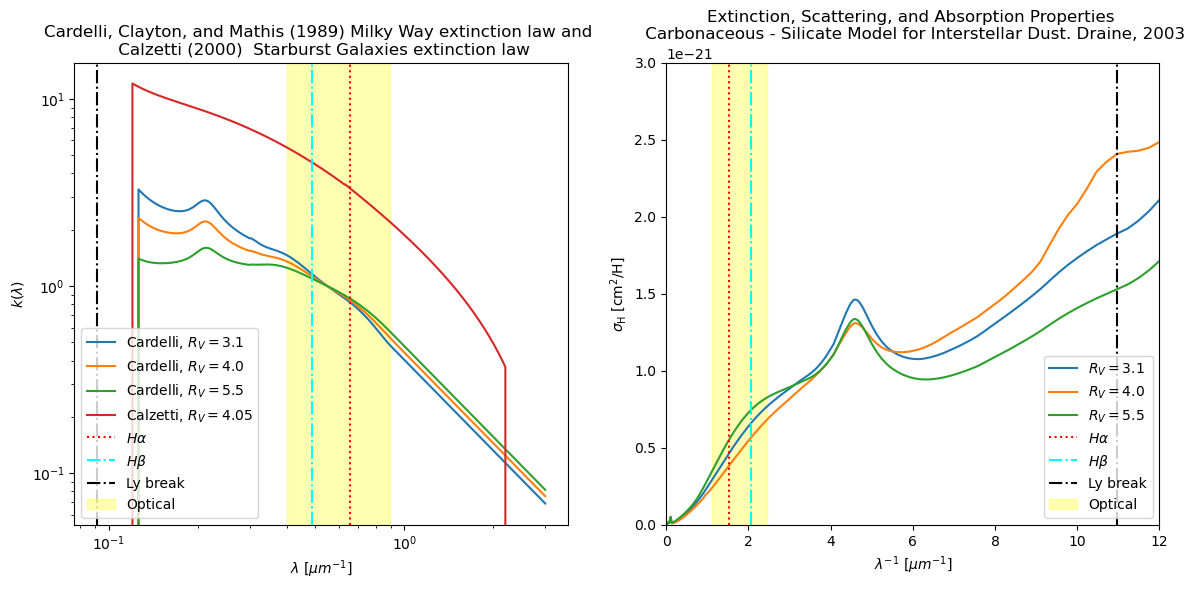

k(Ha) = 0.82 (Cardelli), 3.33 (Calzetti)
k(Hb) = 1.16 (Cardelli), 4.60 (Calzetti)


In [24]:
### === Dust extinction laws === ###

def ccm_extinction(wavelength, R_V=3.1):
    """
    Compute the CCM extinction curve k(λ) as a function of wavelength.
    
    Parameters:
        wavelength : float or numpy array
            Wavelength(s) in microns (µm).
        R_V : float
            Total-to-selective extinction ratio (default is 3.1).
    
    Returns:
        k_lambda : float or numpy array
            The extinction curve k(λ) = A(λ) / E(B-V).
    """
    wavelength = np.atleast_1d(wavelength)
    x = 1.0 / wavelength  # Convert wavelength to inverse microns
    k_lambda = np.zeros_like(x)

    # Infrared (x < 1.1 μm⁻¹)
    mask_ir = (x >= 0.3) & (x < 1.1)
    k_lambda[mask_ir] = 0.574 * x[mask_ir]**1.61 - 0.527 * x[mask_ir]**1.61 / R_V

    # Optical-NIR (1.1 ≤ x < 3.3 μm⁻¹)
    mask_opt = (x >= 1.1) & (x < 3.3)
    y = x - 1.82
    a_nuv = (
        1 + 0.17699 * y - 0.50447 * y**2 - 0.02427 * y**3 +
        0.72085 * y**4 + 0.01979 * y**5 - 0.77530 * y**6 + 0.32999 * y**7
    )
    b_nuv = (
        1.41338 * y + 2.28305 * y**2 + 1.07233 * y**3 - 5.38434 * y**4 -
        0.62251 * y**5 + 5.30260 * y**6 - 2.09002 * y**7
    )
    k_lambda[mask_opt] = a_nuv[mask_opt] + b_nuv[mask_opt] / R_V


    # UV and Far-UV (3.3 ≤ x ≤ 8 μm⁻¹)
    mask_fuv = (x >= 3.3) & (x <= 8.0)

    # Add Drude bump for x > 5.9
    F_a = np.where(x < 5.9, 0, -0.04473*(x-5.9)**2 - 0.009779*(x-5.9)**3)
    F_b = np.where(x < 5.9, 0, 0.2130*(x-5.9)**2 + 0.1207*(x-5.9)**3)
    
    a_fuv = (
        1.752 - 0.316 * x - 0.104 / ((x - 4.67)**2 + 0.341) + F_a
    )
    b_fuv = (
        -3.090 + 1.825 * x + 1.206 / ((x - 4.67)**2 + 0.341) + F_b
    )
    k_lambda[mask_fuv] = a_fuv[mask_fuv] + b_fuv[mask_fuv] / R_V

    return k_lambda[0] if wavelength.size == 1 else k_lambda


def calzetti_extinction(wavelength, R_V=4.05):
    """
    Compute the Calzetti attenuation curve k(λ) as a function of wavelength.
    
    Parameters:
        wavelength : float or numpy array
            Wavelength(s) in microns (µm).
        R_V : float
            Total-to-selective extinction ratio (default is 4.05).
    
    Returns:
        k_lambda : float or numpy array
            The attenuation curve k(λ) = A(λ) / E(B-V)_stars.
    """
    wavelength = np.atleast_1d(wavelength)
    k_lambda = np.zeros_like(wavelength)
    
    # UV to optical: 0.12 µm ≤ λ < 0.63 µm
    uv_opt_mask = (wavelength >= 0.12) & (wavelength < 0.63)
    lambda_uv_opt = wavelength[uv_opt_mask]
    k_lambda[uv_opt_mask] = (
        2.659 * (-2.156 + 1.509 / lambda_uv_opt - 0.198 / lambda_uv_opt**2 + 0.011 / lambda_uv_opt**3) + R_V
    )
    
    # Optical to NIR: 0.63 µm ≤ λ ≤ 2.2 µm
    opt_nir_mask = (wavelength >= 0.63) & (wavelength <= 2.2)
    lambda_opt_nir = wavelength[opt_nir_mask]
    k_lambda[opt_nir_mask] = (
        2.659 * (-1.857 + 1.040 / lambda_opt_nir) + R_V
    )

    return k_lambda[0] if wavelength.size == 1 else k_lambda

# Fitzpatrick DUST EXTINCTION 
# https://www.astro.princeton.edu/~draine/dust/extcurvs/kext_albedo_WD_MW_3.1_60_D03.all

import os
from scipy.interpolate import interp1d

dust_extinction = {}
R_V = ['3.1','4.0','5.5']

for i,filename in enumerate(os.listdir('dust_models')):
    if filename.endswith('.all'):  # Only process .all files
        file_path = os.path.join('dust_models', filename)

        # Initialize lists for lambda and C_ext/H
        lambda_values = []
        C_ext_H_values = []

        with open(file_path, "r") as file:
            lines = file.readlines()
            for line in lines[80:]:  # Start reading from the 80th line
                columns = line.split()
                if len(columns) >= 4:
                    try:
                        # Extract lambda and C_ext/H values
                        lambda_values.append(float(columns[0]))  
                        C_ext_H_values.append(float(columns[3]))  
                        
                    except ValueError:
                        continue
        
        # interpolate
        extinction_H_curve = interp1d(lambda_values,C_ext_H_values)
        
        # Add the data to the dictionary with the filename as key
        dust_extinction[R_V[i]] = {
            'lambda': lambda_values,
            'extinction_H_curve': extinction_H_curve
        }

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,2,figsize=(14,6))

w = np.linspace(0.1, 3, 1000)
ax[0].plot(w, ccm_extinction(w), label='Cardelli, $R_V=3.1$')
ax[0].plot(w, ccm_extinction(w,R_V = 4.0), label='Cardelli, $R_V=4.0$')
ax[0].plot(w, ccm_extinction(w,R_V = 5.5), label='Cardelli, $R_V=5.5$')
ax[0].plot(w, calzetti_extinction(w), label='Calzetti, $R_V=4.05$')

ax[0].set(xscale = "log", yscale= "log", xlabel = "$\lambda$ [$\mu m^{-1}$]", ylabel = "$k(\lambda$)")

wavelength_Ha = 656.281e-7    # Ha line (cm)
wavelength_Hb = 486.135e-7    # Hb line (cm)
Ly_break = 91.2e-7            # Lyman-break wavelength (cm)

ax[0].axvline(x=wavelength_Ha * 1e4, color='red', linestyle=':', label='$H\\alpha$')
ax[0].axvline(x=wavelength_Hb * 1e4, color='cyan', linestyle='-.', label='$H\\beta$')
ax[0].axvline(x=Ly_break * 1e4, color='black', linestyle='-.', label='Ly break')

y_min, y_max = ax[0].get_ylim()
ax[0].set_ylim(y_min,y_max)
ax[0].fill_between(w, y_min, y_max, where=(w >= 0.4) & (w <= 0.9),
                color='yellow', alpha=0.3, label="Optical")

ax[0].legend()
ax[0].set_title("Cardelli, Clayton, and Mathis (1989) Milky Way extinction law and \n Calzetti (2000)  Starburst Galaxies extinction law")

for rv in R_V:

    w = np.array(dust_extinction[rv]['lambda'])
    ax[1].plot(1/w, dust_extinction[rv]['extinction_H_curve'](w),label=f"$R_V = ${rv}")

ax[1].axvline(x = 1/(wavelength_Ha*1e4),c='red',linestyle=':',label='$H\\alpha$')
ax[1].axvline(x = 1/(wavelength_Hb*1e4),c='cyan',linestyle='-.',label='$H\\beta$')
ax[1].axvline(x = 1/(Ly_break*1e4), color='black', linestyle='-.', label='Ly break')

ax[1].fill_between(1/w, 0, 3e-21, where=(1/w <= 1/0.4) & (1/w >= 1/0.9),
                 color='yellow', alpha=0.3, label="Optical")

ax[1].set(xlim=(0, 12), ylim=(0, 30e-22),
           xlabel="$\\lambda^{-1}$ [$\\mu m^{-1}$]", ylabel="$\\sigma_\\text{H}$ [$\\mathrm{cm^2 / H}$]")
ax[1].legend(loc='lower right')
ax[1].set_title("Extinction, Scattering, and Absorption Properties \n Carbonaceous - Silicate Model for Interstellar Dust. Draine, 2003")


plt.show()

print(f"k(Ha) = {ccm_extinction(wavelength_Ha*1e4):.2f} (Cardelli), {calzetti_extinction(wavelength_Ha*1e4):.2f} (Calzetti)")
print(f"k(Hb) = {ccm_extinction(wavelength_Hb*1e4):.2f} (Cardelli), {calzetti_extinction(wavelength_Hb*1e4):.2f} (Calzetti)")


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy.io import fits

filter = ['Ha', 'Hb', 'g', 'r', 'i']
file_paths = {f: f'data/cleaned_calibrated/{f}_calibrated.fit' for f in filter}
filter_cmap = {'Ha': 'hot','Hb': 'magma','g': 'bone','r': 'hot','i': 'copper'}
image = {}
sigma = {}

for f in filter:
    with fits.open(file_paths[f]) as hdul:
        image[f] = hdul[0].data
        header = hdul[0].header
        sigma[f] = hdul[0].header['sigma']

with fits.open('data/cleaned_calibrated/Ha_calibrated.fit'):
    params_ra = [header.get(f'RA_A{i}') for i in range(3)]
    params_dec = [header.get(f'DEC_B{i}') for i in range(3)]

def xy_to_radec(x, y):
    """
    Transform grid of (x, y) to (RA, Dec) coordinates.
    """
    ra = params_ra[0] + params_ra[1] * x + params_ra[2] * y
    dec = params_dec[0] + params_dec[1] * x + params_dec[2] * y
    return ra, dec

def radec_to_xy(ra, dec):
    A = np.array([[params_ra[1], params_ra[2]],
                  [params_dec[1], params_dec[2]]])
    b = np.array([ra - params_ra[0], dec - params_dec[0]])
    # Solve the linear system A * [x, y] = b
    x, y = np.linalg.solve(A, b)
    return x, y

stars_astrometry = []

with fits.open("data/astrometry.fit") as hdul:
    if len(hdul) > 1:
        table_hdu = hdul[1]  

        if table_hdu.data.ndim == 1:
            table = np.stack(table_hdu.data)

        for row in table:
            stars_astrometry.append({'ra': row[0], 'dec': row[1], 'x': row[2], 'y': row[3]})

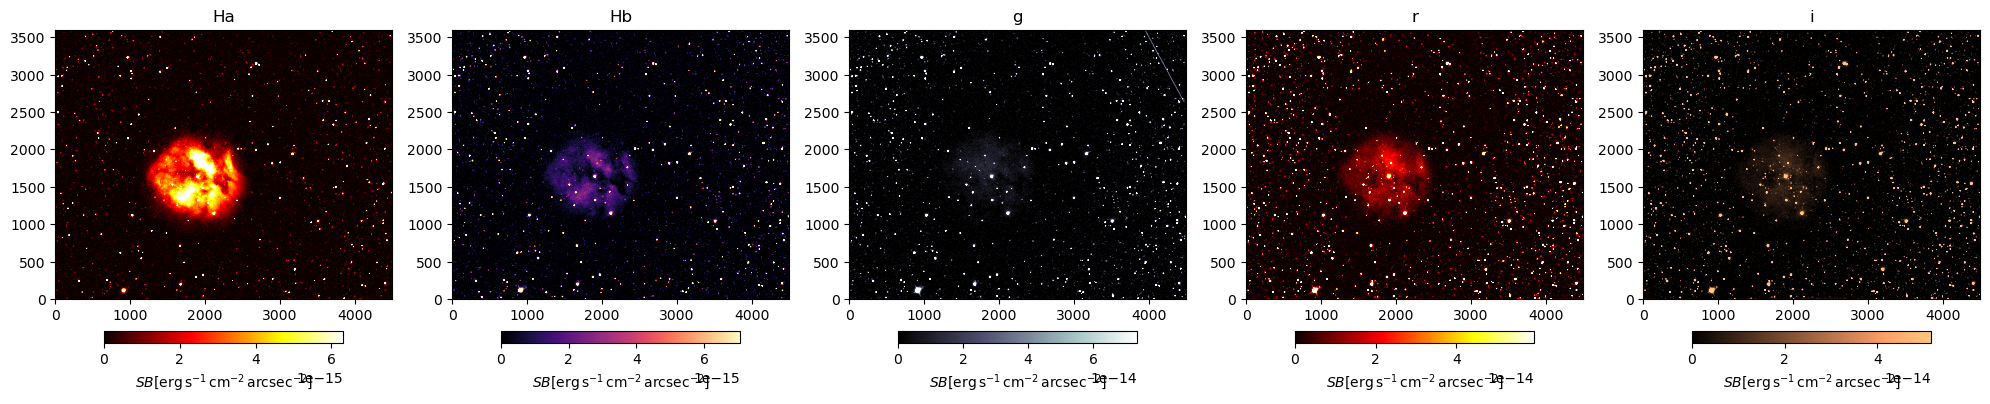

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, f in enumerate(filter):
    im = axes[i].imshow(image[f], clim=[0, np.quantile(image[f], 0.99)], cmap=filter_cmap[f], origin='lower')
    plt.colorbar(im, ax=axes[i], location='bottom', fraction=0.0375, pad=0.1, label="$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$")
    axes[i].set_title(f)

plt.tight_layout()
plt.show()


In the Hα (656.3 nm) filter, we observe the Balmer recombination transition (n=3 → n=2), a strong emission line tracing ionized hydrogen. The Hβ (486.1 nm) filter captures the n=4 → n=2 transition, another Balmer line that is fainter than Hα. The r-band includes Hα emission but at a lower signal-to-noise ratio (SNR) due to its broad bandwidth. Similarly, the g-band captures Hβ with reduced SNR, along with blue starlight. The i-band primarily detects starlight scattered from gas and dust within the nebula and possibly fainter recombination lines (n=4 → n=3).

# 1. Balmer Decrement and Extinction in the HII region

Dust extinction is defined by:

$$L_{obs}(\lambda) = L_{int}(\lambda)10^{-0.4A_\lambda} = L_{int}(\lambda)10^{-0.4k(\lambda)E(B-V)}$$

The relationship between the nebular emission-line color excess and the Balmer decrement is therefore given by:

$$E(B - V) = \frac{E(\mathrm{H}\beta - \mathrm{H}\alpha)}{k(\lambda_{\mathrm{H}\beta}) - k(\lambda_{\mathrm{H}\alpha})} = \frac{2.5}{k(\lambda_{\mathrm{H}\beta}) - k(\lambda_{\mathrm{H}\alpha})} \log_{10} \left[ \frac{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}}{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}}} \right]$$

where $(k(\lambda_{\mathrm{H}\beta}))$ and $(k(\lambda_{\mathrm{H}\alpha}))$ are the reddening curves evaluated at $H\beta$ and $H\alpha$ wavelengths, respectively. The factor $E(\mathrm{H}\beta - \mathrm{H}\alpha)$ is analogous to the color excess but defined for $H\beta$ and $H\alpha$ instead of the B and V bands. Then, $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}$ is the observed Balmer decrement, and $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}}$ is the intrinsic or unreddened Balmer decrement, which is calculated theoretically.

The intrinsic Balmer decrement remains roughly constant for typical gas conditions in star-forming galaxies (see Osterbrock 1989). In our analysis, we assume the value of $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}} = 2.86$, corresponding to a temperature $T = 10^4 \, \mathrm{K}$ and an electron density $n_e = 10^2 \, \mathrm{cm}^{-3}$ for Case B recombination (Osterbrock 1989). This choice is standard for star-forming galaxies in the literature. Thus, the nebular color excess is given by the following equation:

$$E(B - V) = 1.97 \log_{10} \left( \frac{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}}{2.86} \right)$$

### Case B Recombination:

***Lyman Continuum Photons are Reabsorbed***:
When a hydrogen atom recombines with an electron and transitions to the n=1 ground state, it emits a photon in the Lyman series (e.g., Lyman-α). Under Case B, these Lyman photons are absorbed and reprocessed within the gas, instead of escaping.
This reabsorption occurs because the gas is dense enough to be optically thick to ultraviolet photons in the Lyman series.

***Other Transitions are Optically Thin***:
Photons from transitions to levels n>1n (e.g., Hα from n=3→2) can escape the nebula without significant reabsorption.
This results in the prominence of Balmer, Paschen, and other series of hydrogen emission lines in the spectrum.


In [5]:
### === TASK ONE: EXTINCTION THROUGH BALMER DECREMENTS === ###

**1. Mask stars**

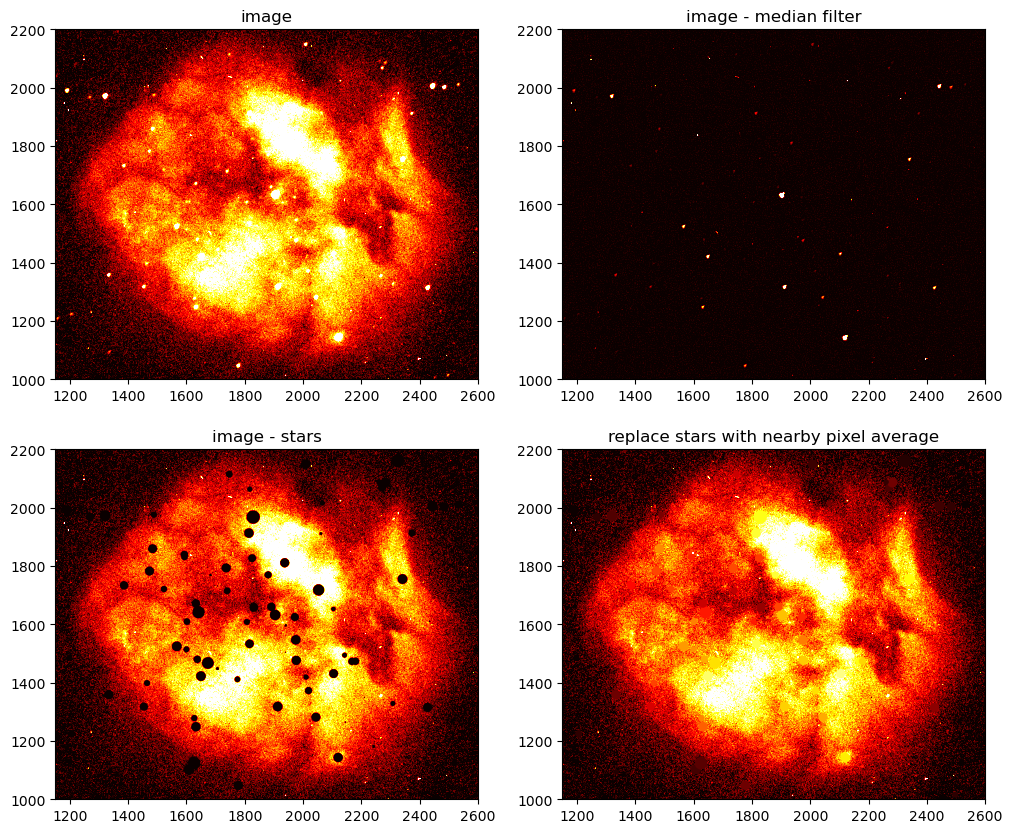

In [3]:
from astropy.modeling import models, fitting
from scipy.ndimage import median_filter

fig,axes = plt.subplots(2,2,figsize=(12,10))
axes = axes.flatten()

axes[0].imshow(image['Ha'], cmap=filter_cmap['Ha'],clim=[0, np.quantile(image['Ha'], 0.99)],origin='lower')
axes[0].set_title("image")

# This subtraction highlights stars while suppressing extended nebular structures, making it easier to detect and mask stars:
filtered_image = image['Ha'] - median_filter(image['Ha'], size=10)

axes[1].imshow(filtered_image, cmap=filter_cmap['Ha'],clim=[0, np.quantile(image['Ha'], 0.999)],origin='lower')
axes[1].set_title("image - median filter")

masked_Ha_ = np.copy(image['Ha'])  
masked_Hb_ = np.copy(image['Hb'])

masked_Ha = np.copy(image['Ha'])  
masked_Hb = np.copy(image['Hb']) 

for star in stars_astrometry:
    if 1000 < star['x'] < 3000 and 800 < star['y'] < 2400:
        l = 25
        rectangle = filtered_image[int(star['y'] - l):int(star['y'] + l), 
                                        int(star['x'] - l):int(star['x'] + l)]
        y, x = np.mgrid[:rectangle.shape[0], :rectangle.shape[1]]
        g_init = models.Gaussian2D(amplitude=rectangle.max(), x_mean=l, y_mean=l, x_stddev=5, y_stddev=5)
        fit = fitting.LevMarLSQFitter()
        g_fit = fit(g_init, x, y, rectangle)
            
        refined_x = star['x'] - l + g_fit.x_mean.value
        refined_y = star['y'] - l + g_fit.y_mean.value

        sigma_x, sigma_y = g_fit.x_stddev.value, g_fit.y_stddev.value
        fwhm_x = 2.355 * sigma_x
        fwhm_y = 2.355 * sigma_y
        fwhm = (fwhm_x + fwhm_y) / 2
        y, x = np.ogrid[:masked_Ha.shape[0], :masked_Hb.shape[1]] # circular aperture mask around the star

        # For a symmetric Gaussian, the flux has reduced by approximately 98.89% at 1.5×FWHM
        if fwhm < l/2:
            mask_radius = 2.5 * fwhm 
            mask = (x - refined_x)**2 + (y - refined_y)**2 <= mask_radius**2    
            masked_Ha_[mask] = 0
            masked_Hb_[mask] = 0


            mask_radius_for_averaging = 2.8 * fwhm
            mask_for_averaging = ((x - refined_x)**2 + (y - refined_y)**2 <= mask_radius_for_averaging**2) & \
                                 ((x - refined_x)**2 + (y - refined_y)**2 > mask_radius**2)


            surrounding_pixels_Ha = image['Ha'][mask_for_averaging]  # Pixels outside the mask (complement of mask)
            surrounding_pixels_Hb = image['Hb'][mask_for_averaging]

            # Compute the average of the surrounding pixels
            average_Ha = surrounding_pixels_Ha.mean()
            average_Hb = surrounding_pixels_Hb.mean()

            # Apply the average value to the masked area
            masked_Ha[mask] = average_Ha  # Apply the average to the masked pixels in Ha
            masked_Hb[mask] = average_Hb  # Apply the average to the masked pixels in Hb


axes[2].imshow(masked_Ha_, cmap=filter_cmap['Ha'],clim=[0, np.quantile(image['Ha'], 0.99)],origin='lower')
axes[2].set_title("image - stars")

axes[3].imshow(masked_Ha, cmap=filter_cmap['Ha'],clim=[0, np.quantile(image['Ha'], 0.99)],origin='lower')
axes[3].set_title("replace stars with nearby pixel average")

for i in range(4):
    axes[i].set_xlim(1150,2600)
    axes[i].set_ylim(1000,2200)
plt.show()

del masked_Ha_, masked_Hb_, filtered_image


**2. Smoothing (Low-Pass Filters)**

To achieve a reasonable SNR of at least 5 for E(B−V)E(B−V), rebinning must be performed by combining multiple pixels into a single pixel. This can be done with Low-Pass Filters

A low-pass filter is a type of signal processing filter that allows low-frequency components to pass through while attenuating or suppressing high-frequency components. In the context of image processing, low-pass filters are used for smoothing or blurring images by removing noise or fine details.

$$I'(x,y)=\sum_{u=-k}^k\sum_{v=-k}^k I(x+u,y+v)\cdot h(u,v)$$

- $I(x,y)$: Original image intensity at $(x,y)$
- $I′(x,y)$: Filtered image intensity at $(x,y)$
- $h(u,v)$: Filter kernel (defines the filter behavior)
- $k$: Defines the size of the kernel (e.g., 3×3, 5×5).

Filter kernels:

1. Gaussian Filter: Blurs an image using a Gaussian kernel. Smooths edges but introduces slight blurring.
2. Median Filter: Replaces each pixel with the median value of its neighborhood. Good for removing salt-and-pepper noise.
3. Box Filter (Average Filter): Replaces each pixel with the average of its neighborhood.

If the HβHβ​ flux is very low in certain regions, causing the Balmer decrement to appear anomalously high, the question arises whether the measurement is reliable enough to conclude that the decrement is "genuine." You need to check whether the Hβ​ flux is significantly different from zero. A flux near zero might indicate a poor signal-to-noise ratio (SNR), so you should calculate the SNR for both Hα and Hβ​. A very low SNR in Hβ​ could lead to significant uncertainties in the decrement. For instance, if the SNR of Hβ​ is low, then its measurement might be dominated by noise rather than a true physical feature.


In [4]:
# GAUSSIAN FILTER

from scipy.ndimage import gaussian_filter

sigma_f = 10

masked_Ha = np.nan_to_num(masked_Ha, np.median(masked_Ha))
masked_Hb = np.nan_to_num(masked_Hb, np.median(masked_Hb))
smoothed_image_Ha_gauss = gaussian_filter(masked_Ha, sigma=sigma_f)
smoothed_image_Hb_gauss = gaussian_filter(masked_Hb, sigma=sigma_f)

In [5]:
# MEDIAN FILTER

from scipy.ndimage import median_filter

size = 10  

smoothed_image_Ha_median = median_filter(masked_Ha, size=size)
smoothed_image_Hb_median = median_filter(masked_Hb, size=size)

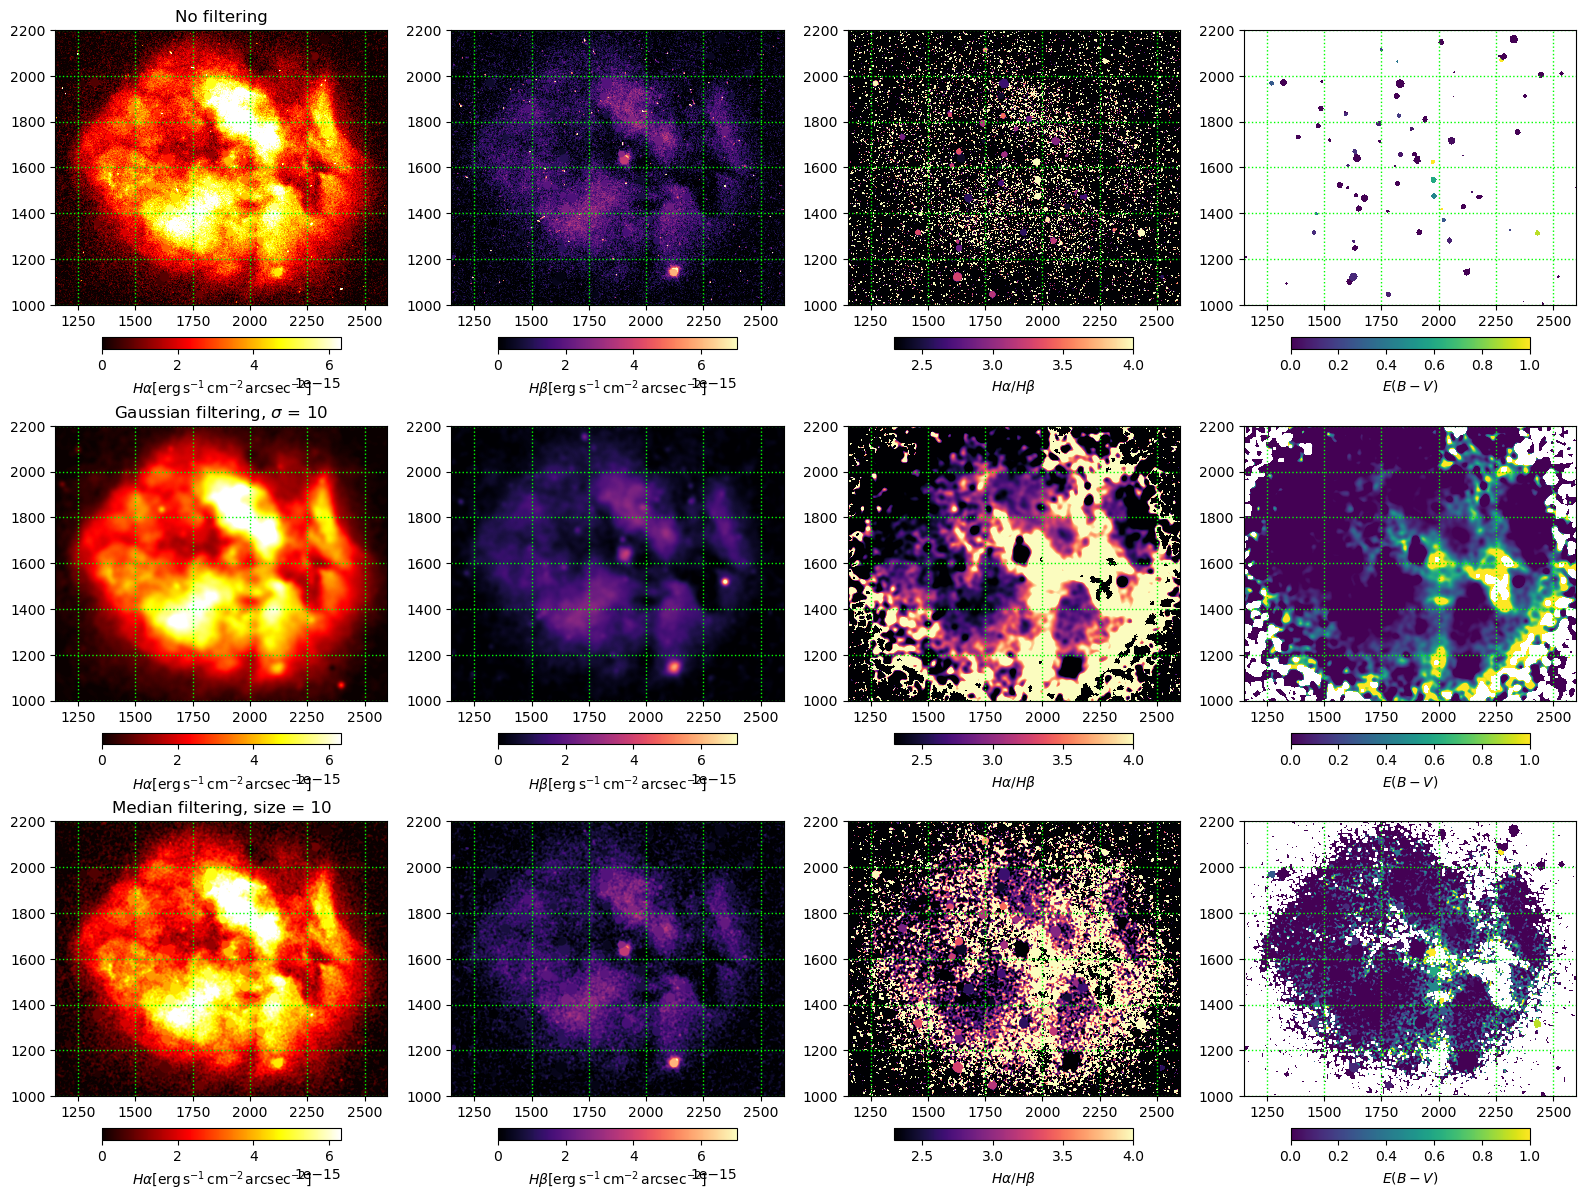

In [18]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

### === No filtering === ###

im0 = axes[0,0].imshow(masked_Ha,origin='lower',clim=[0, np.quantile(image['Ha'], 0.99)], cmap='hot')
fig.colorbar(im0, ax=axes[0,0], location='bottom', fraction=0.0375, pad=0.1, label='$H\\alpha [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$')

im1 = axes[0,1].imshow(masked_Hb,clim=[0, np.quantile(image['Hb'], 0.99)], origin='lower', cmap='magma')
fig.colorbar(im1, ax=axes[0,1], location='bottom', fraction=0.0375, pad=0.1,label='$H\\beta [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$')

im2 = axes[0,2].imshow(masked_Ha/masked_Hb,clim=[2.3,4], origin='lower', cmap='magma')
fig.colorbar(im2, ax=axes[0,2], location='bottom', fraction=0.0375, pad=0.1,label='$H\\alpha/H\\beta$')

EBmV = 1.97 * np.log10(masked_Ha/masked_Hb /2.86)

im3 = axes[0,3].imshow(EBmV, clim = [0,1], origin='lower', cmap='viridis') 
fig.colorbar(im3, ax=axes[0,3], location='bottom', fraction=0.0375, pad=0.1,label='$E(B-V)$')

axes[0,0].set_title("No filtering")

### === Gaussian filtering === ###

im0 = axes[1,0].imshow(smoothed_image_Ha_gauss,origin='lower',clim=[0, np.quantile(image['Ha'], 0.99)], cmap='hot')
fig.colorbar(im0, ax=axes[1,0], location='bottom', fraction=0.0375, pad=0.1, label='$H\\alpha [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$')

im1 = axes[1,1].imshow(smoothed_image_Hb_gauss,clim=[0, np.quantile(image['Hb'], 0.99)], origin='lower', cmap='magma')
fig.colorbar(im1, ax=axes[1,1], location='bottom', fraction=0.0375, pad=0.1,label='$H\\beta [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$')

im2 = axes[1,2].imshow(smoothed_image_Ha_gauss/smoothed_image_Hb_gauss,clim=[2.3,4], origin='lower', cmap='magma')
fig.colorbar(im2, ax=axes[1,2], location='bottom', fraction=0.0375, pad=0.1,label='$H\\alpha/H\\beta$')

EBmV = 1.97 * np.log10(smoothed_image_Ha_gauss/smoothed_image_Hb_gauss /2.86)

im3 = axes[1,3].imshow(EBmV, clim = [0,1], origin='lower', cmap='viridis') 
fig.colorbar(im3, ax=axes[1,3], location='bottom', fraction=0.0375, pad=0.1,label='$E(B-V)$')

axes[1,0].set_title("Gaussian filtering, $\sigma$ = 10")

### === Median filtering === ###

im0 = axes[2,0].imshow(smoothed_image_Ha_median,origin='lower',clim=[0, np.quantile(image['Ha'], 0.99)], cmap='hot')
fig.colorbar(im0, ax=axes[2,0], location='bottom', fraction=0.0375, pad=0.1, label='$H\\alpha [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$')

im1 = axes[2,1].imshow(smoothed_image_Hb_median,clim=[0, np.quantile(image['Hb'], 0.99)], origin='lower', cmap='magma')
fig.colorbar(im1, ax=axes[2,1], location='bottom', fraction=0.0375, pad=0.1,label='$H\\beta [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsec^{-2}}]$')

im2 = axes[2,2].imshow(smoothed_image_Ha_median/smoothed_image_Hb_median,clim=[2.3, 4], origin='lower', cmap='magma')
fig.colorbar(im2, ax=axes[2,2], location='bottom', fraction=0.0375, pad=0.1,label='$H\\alpha/H\\beta$')

EBmV = 1.97 * np.log10(smoothed_image_Ha_median/smoothed_image_Hb_median /2.86)

im3 = axes[2,3].imshow(EBmV, clim = [0,1], origin='lower', cmap='viridis') 
fig.colorbar(im3, ax=axes[2,3], location='bottom', fraction=0.0375, pad=0.1,label='$E(B-V)$')

axes[2,0].set_title("Median filtering, size = 10")

axes = axes.flatten()
for i in range(12):
    axes[i].set_xlim(1150,2600)
    axes[i].set_ylim(1000,2200)
    axes[i].set_aspect('equal')  # Ensures the grid cells are square
    axes[i].grid(visible=True, linestyle=':', linewidth=1,c='lime')

plt.tight_layout()
plt.show()


(1000.0, 2200.0)

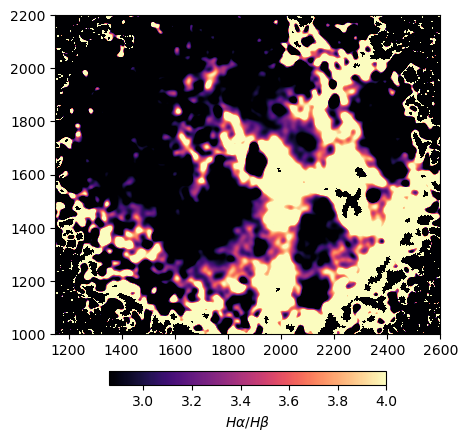

In [16]:
plt.imshow(smoothed_image_Ha_gauss/smoothed_image_Hb_gauss, clim = [2.86,4], origin='lower', cmap='magma')
plt.colorbar(location='bottom', fraction=0.0375, pad=0.1,label='$H\\alpha/H\\beta$')
plt.xlim(1150,2600)
plt.ylim(1000,2200)

**Average Value**

In [29]:
# Central star is BD+46 3474 ( 	21 53 28.849152 	+47 15 59.78412   or    328.370205 	47.266607   J2000 ) 
# https://simbad.u-strasbg.fr/simbad/sim-coo?&Coord=328.375681513405d47.263674788998d&CooFrame=FK5&Radius=2&Radius.unit=arcmin
center_x, center_y = radec_to_xy(328.370134,47.266320) 

R_ext = 500 # pixels

from photutils.aperture import CircularAperture, aperture_photometry

aperture = CircularAperture((center_x, center_y), R_ext)
    
# Ha
phot_Ha = aperture_photometry(masked_Ha, aperture, error = np.full(masked_Ha.shape, sigma['Ha']))
F_Ha = phot_Ha['aperture_sum'][0]
F_Ha_err = phot_Ha['aperture_sum_err'][0]   

# Hb
phot_Hb = aperture_photometry(masked_Hb, aperture, error = np.full(masked_Hb.shape, sigma['Hb']))
F_Hb = phot_Hb['aperture_sum'][0]
F_Hb_err = phot_Hb['aperture_sum_err'][0]



In [34]:
print(f"Total flux in Ha filter is  {F_Ha:.2e} ± {F_Ha_err:.2e}" )

print(f"Total flux in Hb filter is  {F_Hb:.2e} ± {F_Hb_err:.2e}")

Balmer_mean = F_Ha / F_Hb
Balmer_mean_err = np.sqrt((F_Ha_err/F_Hb)**2 + (F_Hb_err*F_Ha/F_Hb**2)**2)

print(f"Average Ha/Hb decrement is  {Balmer_mean:.2f} ± {Balmer_mean_err:.2e}")

EBmV_mean = 1.97 * np.log10(Balmer_mean/2.86)
EBmV_mean_err = 1.97 * Balmer_mean_err /(np.log(10)*Balmer_mean/2.75)

print(f"Average E(B-V) is  {EBmV_mean:.2f} ± {EBmV_mean_err:.2e}")

Total flux in Ha filter is  2.65e-09 ± 1.66e-12
Total flux in Hb filter is  8.67e-10 ± 2.28e-12
Average Ha/Hb decrement is  3.05 ± 8.25e-03
Average E(B-V) is  0.06 ± 6.35e-03


In [14]:
print(3.3*0.34)
tau = 3.3*0.06

1.122


In [ ]:
parsec = 3.086e18             # cm
distance = 714 * parsec
n_H = 1e2                    # Hydrogen number density typical for HII region [cm^-3]
x = 0.1                      # ionized fraction
csi = 20                      # dust parameter

# 2. Dust extinction on stars embedded in the Nebula using GAIA DR3 xp sampled spectra

**GAIA DR3 dataset**

Photometric and Spectrocopic data include:

- phot_g_mean_mag (E): mean magnitude in the GAIA G-band. This is the observed brightness of the star in the G-band, which GAIA measures through its photometric observations.

- bp_rp (E): difference between the magnitudes in the blue photometric band (BP) and the red photometric band (RP). This is also known as the color index. GAIA measures the star’s brightness in both the blue (BP) and red (RP) bands, and the difference between these values gives the color index, which is related to the star's temperature.

- phot_variable_flag (13A): A flag indicating whether the star is variable in brightness.

- non_single_star (I): A flag indicating whether the star is part of a binary or multiple star system. Determined through astrometric measurements, such as the star's motion or other evidence of companions.

- teff_gspphot (E): effective temperature of the star, derived from the star's color and luminosity using models of stellar atmospheres, typically from the GAIA photometric data and spectroscopic observations.

- logg_gspphot (E): surface gravity of the star, measured in log units (logarithmic scale). log(cm/s²). This is derived from the star’s luminosity, radius, and mass. It’s related to the star's stage in its lifecycle. 

- mh_gspphot (E): metallicity of the star, given in logarithmic units (dex). Metallicity is derived from the star’s spectrum and photometric measurements. It indicates the abundance of elements heavier than hydrogen and helium in the star.

- distance_gspphot (E): The distance to the star in pc, derived from the parallax measurements.

- azero_gspphot, ag_gspphot, ebpminrp_gspphot (E): extinction and reddening parameters that describe how the star’s light is affected by interstellar dust.

**GAIA Sampled XP Spectra** refer to the low-resolution prism-dispersed spectra obtained by the BP/RP (Blue Photometer / Red Photometer) spectrometers on board the GAIA space telescope. These spectra are part of the XP (Xp = eXtra Photometric) data, and they provide crucial spectral information across a broad wavelength range. BP (Blue Photometer): Covers the 330–680 nm range. RP (Red Photometer): Covers the 640–1050 nm range. These instruments disperse light at low resolution (~20–100), meaning they provide broad spectral energy distribution (SED) information rather than high-resolution spectral lines.

In [19]:
### === Open data catalogue === ###

with fits.open('data/GAIA_field_m>13.fits') as hdul:
    #print(hdul[1].header)
    columns = hdul[1].columns.names  
    GAIA_table = hdul[1].data

import pandas as pd
df = pd.DataFrame(GAIA_table)

from IPython.display import display, HTML
display(HTML("""
<style>
    .scrollable-table-container {
        overflow: auto; /* Enables scrolling */
        max-height: 500px; /* Set maximum height for vertical scrolling */
        border: 1px solid #ccc; /* Optional: Add border for clarity */
        padding: 5px;
    }
    .scrollable-table-container table {
        display: block; /* Ensures proper rendering for wide tables */
        white-space: nowrap; /* Prevent text wrapping in cells */
    }
</style>
<div class="scrollable-table-container">
""" + df.to_html(index=False) + "</div>"))


In [20]:
R_sun = 6.96e10                 # solar radius in cm
T_sun = 5778                    # K
L_sun = 3.83e33                 # erg/s
M_bol_sun = 4.74                # mag

parsec = 3.086e18               # cm


In [21]:
# download xp spectra
from astroquery.gaia import Gaia
retrieval_type = 'XP_SAMPLED'     # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL'     # Options are: 'INDIVIDUAL' or 'RAW'
data_release   = 'Gaia DR3'       # Options are: 'Gaia DR3' (default), 'Gaia DR2'
datalink = Gaia.load_data(ids=GAIA_table['source_id'],data_release=data_release, retrieval_type=retrieval_type, data_structure=data_structure);

stars_gaia = []

for i in range(len(GAIA_table)): 

    source_id = GAIA_table[i]['source_id']  
    
    ra = GAIA_table[i]['ra']
    dec = GAIA_table[i]['dec']
    parallax = GAIA_table[i]['parallax']   # mas
    distance = 1/(parallax*1e-3)           # pc

    #distance = GAIA_table[i]['distance_gspphot']
    target_separation = GAIA_table[i]['target_separation (deg)'] 
    m_g = GAIA_table[i]['phot_g_mean_mag']
    color_index = GAIA_table[i]['bp_rp']
    EBmV = GAIA_table[i]['ebpminrp_gspphot']
    T_eff = GAIA_table[i]['teff_gspphot']

    M_g = m_g - 5*np.log10(distance) + 5
    BC_g = -0.1 + 0.06*(color_index)-0.0015*(color_index)**2
    M_bol = M_g + BC_g 
    L = 10**((M_bol_sun-M_bol)/2.5)   # in L_sun
    R = L**(1/2) * (T_sun/T_eff)**2   # in R_sun
    
    x,y = radec_to_xy(ra,dec)
        
    wavelengths = np.array(datalink[f"XP_SAMPLED-Gaia DR3 {GAIA_table['source_id'][i]}.xml"][0].to_table().as_array()['wavelength'])
    flux = np.array(datalink[f"XP_SAMPLED-Gaia DR3 {GAIA_table['source_id'][i]}.xml"][0].to_table().as_array()['flux'])
    flux_err = np.array(datalink[f"XP_SAMPLED-Gaia DR3 {GAIA_table['source_id'][i]}.xml"][0].to_table().as_array()['flux_error'])
    
    w = 10 * wavelengths  # wavelength in armstrong (GAIA original data gives wavelength in nm)
    flux = 1.e2 * flux  # specific flux in erg/s/cm2/armstrong (GAIA original data gives fluxes in W/m^2/nm)
    flux_err = 1.e2 * flux_err

    stars_gaia.append({'ra': ra, 'dec': dec, 'x': x, 'y': y, 
                       'parallax': parallax,
                       'distance': distance,
                       'target_separation_arcmin': target_separation * 60,
                       'T_eff': T_eff,
                       'L': L,
                       'R': R,
                       'EBmV': EBmV,
                        'spectra': [w,flux,flux_err]}
                     )

    

"Important:  Gaia archive will be intermittently unavailable due to scheduled maintenance on 03-02-2025 from 08:00 to 10:00 (CET)"


In [22]:
h = 6.62607015e-27                 # Planck's constant (erg·s)
c = 3.0e10                         # Speed of light (cm/s)
k_B = 1.380649e-16                 # Boltzmann's constant (erg/K)
sigma_Stefan_Boltzmann = 5.67e-5   # cgs
parsec = 3.086e18                  # cm

def intrinsic_flux(w,T_star,R_star,distance):
    """
    Assuming perfect black body of temperature T and emitting surface R 
    w in Armstrong
    returns intrinsic specific flux in erg/s/cm^2/armstrong 
    """
    w_cm = w * 1e-8 # wavelength in cm
    
    black_body = (2 * h * c**2) / (w_cm**5) * 1 / (np.exp((h * c) / (w_cm * k_B * T_star)) - 1)

    return 1e-8 * (R_star**2/distance**2) * np.pi * black_body


#########################################

def observed_flux(w,T_star,R_star,distance,
                  EBmV, Rv,
                  Cardelli = False,
                  Calzetti = False, 
                  Fitzpatrick = False, n_H = 1e2, R_cloud = 0.8*parsec):
    """
    Dust absorption
    w in Armstrong
    returns observed specific flux in erg/s/cm^2/armstrong 
    """
    w_micron = w*1e-4

    if Cardelli:
        return intrinsic_flux(w,T_star,R_star,distance) * np.exp(-ccm_extinction(w_micron,Rv) * EBmV)
        
    if Calzetti:
        return intrinsic_flux(w,T_star,R_star,distance) * np.exp(-calzetti_extinction(w_micron,Rv) * EBmV)


# Central star

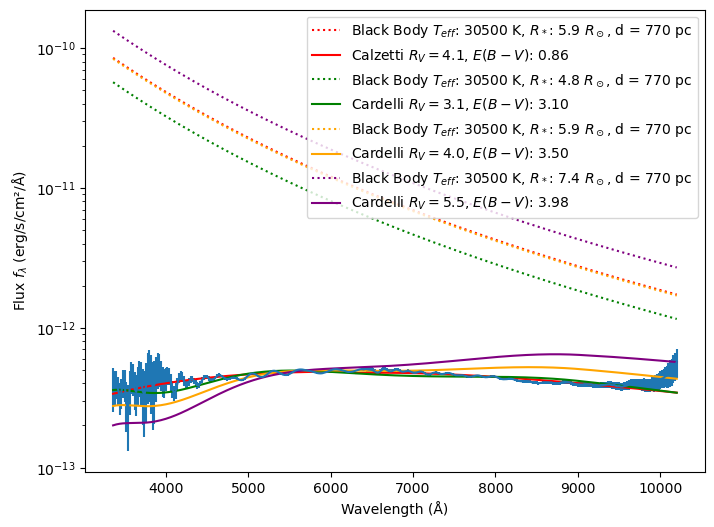

In [25]:
# Central star is BD+46 3474 ( 21 53 28.849152 +47 15 59.78412 or 328.370205 47.266607 J2000 ) 
# https://simbad.u-strasbg.fr/simbad/sim-coo?&Coord=328.375681513405d47.263674788998d&CooFrame=FK5&Radius=2&Radius.unit=arcmin

# From Rojas et al., 2014
T_eff = 30500                  # star surface temperature [K] 

R_star = 5.2 * R_sun            # star radius 

distance = 770 * parsec

w = stars_gaia[0]['spectra'][0]
flux = stars_gaia[0]['spectra'][1]
flux_err = stars_gaia[0]['spectra'][2]

fig,ax = plt.subplots(figsize=(8,6))

plt.errorbar(w,flux,flux_err)
plt.ylabel('Flux $f_\lambda$ (erg/s/cm²/Å)', fontsize=10)
plt.xlabel('Wavelength (Å)', fontsize=10)



from scipy.optimize import curve_fit

## Calzetti ##

p0 = [0.5,1*R_sun]  
popt, pcov = curve_fit(
    lambda w, EBmV, R_star: observed_flux(w, T_eff, R_star, distance, EBmV, Rv=4.1, Calzetti = True),
    w, flux, sigma=flux_err, p0=p0
)
optimized_EBmV, optimized_R_star = popt

flux_black_body = intrinsic_flux(w,T_eff,optimized_R_star,distance)
plt.plot(w, flux_black_body, color='red', linestyle=':',
    label=f"Black Body $T_{{eff}}$: {T_eff:.0f} K, $R_*$: {optimized_R_star/R_sun:.1f} $R_\odot$, d = {distance/parsec:.0f} pc")

fitted_flux = observed_flux(w,T_eff,optimized_R_star,distance, EBmV=optimized_EBmV, Rv=4.1, Calzetti = True)
plt.plot(w, fitted_flux, label=f"Calzetti $R_V = 4.1$, $E(B-V)$: {optimized_EBmV:.2f}", color='red')


## Cardelli #

col = ['g','orange','purple']

for i,rv in enumerate([3.1,4.0,5.5]):

    p0 = [0.5,1*R_sun]  # Initial guess for E(B-V)
    popt, pcov = curve_fit(
        lambda w, EBmV, R_star: observed_flux(w, T_eff, R_star, distance, EBmV, Rv=rv, Cardelli = True),
        w, flux, sigma=flux_err, p0=p0
    )
    optimized_EBmV, optimized_R_star = popt

    flux_black_body = intrinsic_flux(w,T_eff,optimized_R_star,distance)
    plt.plot(w, flux_black_body, color=col[i], linestyle=':',
             label=f"Black Body $T_{{eff}}$: {T_eff:.0f} K, $R_*$: {optimized_R_star/R_sun:.1f} $R_\odot$, d = {distance/parsec:.0f} pc")
    
    fitted_flux = observed_flux(w,T_eff,optimized_R_star,distance, EBmV=optimized_EBmV, Rv=3.1, Cardelli = True)
    plt.plot(w, fitted_flux, label=f"Cardelli $R_V = {rv}$, $E(B-V)$: {optimized_EBmV:.2f}", color=col[i])

plt.yscale("log")
plt.legend()
plt.show()



# Other stars


In [26]:
stars_behind_nebula = [star for star in stars_gaia if star['distance'] > 600 and star['target_separation_arcmin'] < 7]
#print(len(stars_behind_nebula))

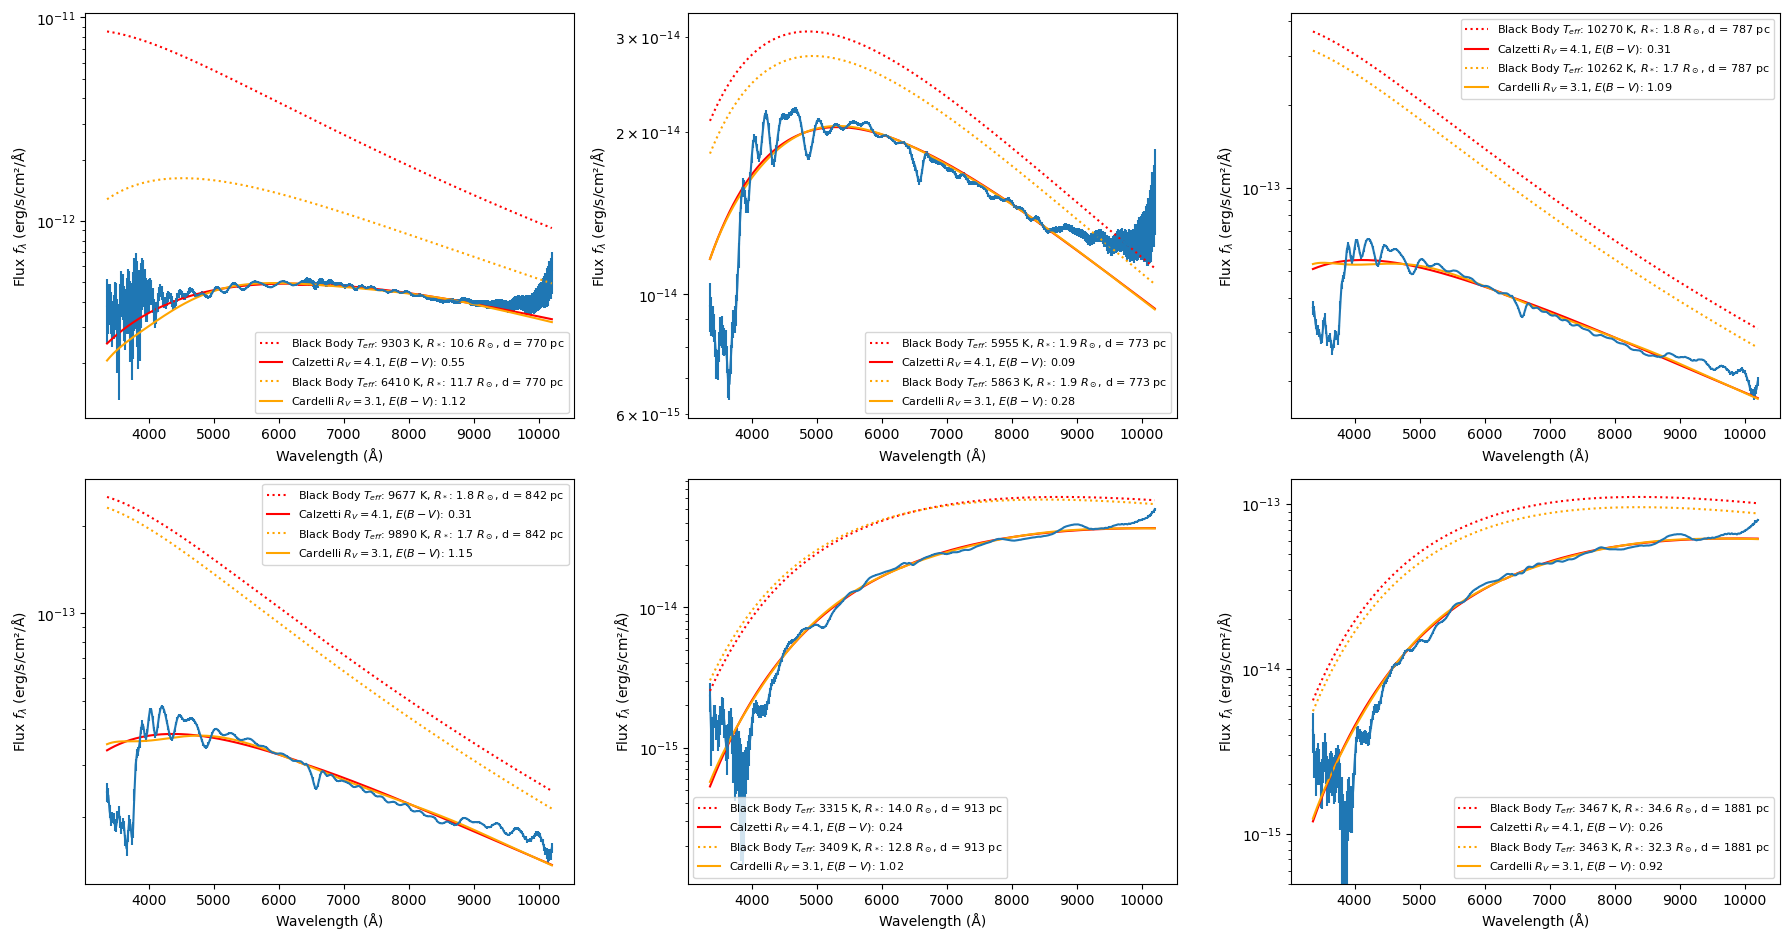

In [27]:
#from scipy.optimize import differential_evolution
from scipy.optimize import curve_fit

EBmV_Calzetti = []
EBmV_Cardelli = []


fig, axes = plt.subplots(2, 3, figsize=(18, 10))  
axes = axes.flatten()

for i,star in enumerate(stars_behind_nebula): 

    #EBmV_gaia = star['EBmV']
    #R_star = star['R'] * R_sun
    distance = star['distance'] * parsec   # cm
    
    w = star['spectra'][0]
    flux = star['spectra'][1]
    flux_err = star['spectra'][2]

    axes[i].errorbar(w,flux,flux_err)

    # Fit stellar radius and E(B-V) 

    ## Calzetti ##
    
    p0 = [0.5,3*T_sun,R_sun]  # Initial guess for E(B-V) and R_star
    popt, pcov = curve_fit(
        lambda w, EBmV, T_eff, R_star: observed_flux(w, T_eff, R_star, distance, EBmV, Rv=4.1, Calzetti=True),
        w, flux, sigma=flux_err, p0=p0
    )
    optimized_EBmV, optimized_T, optimized_R = popt

    star['EBmV_fit Calzetti'] = optimized_EBmV

    flux_black_body = intrinsic_flux(w,optimized_T,optimized_R,distance)
    axes[i].plot(w, flux_black_body, color='red', linestyle=':',
                 label=f"Black Body $T_{{eff}}$: {optimized_T:.0f} K, $R_*$: {optimized_R/R_sun:.1f} $R_\odot$, d = {distance/parsec:.0f} pc")

    fitted_flux = observed_flux(w,optimized_T,optimized_R,distance, EBmV=optimized_EBmV, Rv=4.1, Calzetti = True)
    axes[i].plot(w, fitted_flux, label=f"Calzetti $R_V = 4.1$, $E(B-V)$: {optimized_EBmV:.2f}", color='red')

    ## Cardelli ##
    
    p0 = [0.5,T_sun,R_sun]  # Initial guess for E(B-V)
    popt, pcov = curve_fit(
        lambda w, EBmV, T_eff, R_star: observed_flux(w, T_eff, R_star, distance, EBmV, Rv=3.1, Cardelli = True),
        w, flux, sigma=flux_err, p0=p0
    )
    optimized_EBmV, optimized_T, optimized_R = popt

    star['EBmV_fit Cardelli'] = optimized_EBmV

    flux_black_body = intrinsic_flux(w,optimized_T,optimized_R,distance)
    axes[i].plot(w, flux_black_body, color='orange', linestyle=':',
                 label=f"Black Body $T_{{eff}}$: {optimized_T:.0f} K, $R_*$: {optimized_R/R_sun:.1f} $R_\odot$, d = {distance/parsec:.0f} pc")

    fitted_flux = observed_flux(w,optimized_T,optimized_R,distance, EBmV=optimized_EBmV, Rv=3.1, Cardelli = True)
    axes[i].plot(w, fitted_flux, label=f"Cardelli $R_V = 3.1$, $E(B-V)$: {optimized_EBmV:.2f}", color='orange')


    axes[i].set_yscale("log")
    axes[i].set_ylabel('Flux $f_\\lambda$ (erg/s/cm²/Å)', fontsize=10)
    axes[i].set_xlabel('Wavelength (Å)', fontsize=10)
    axes[i].legend(fontsize=8) #loc='upper right'

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()



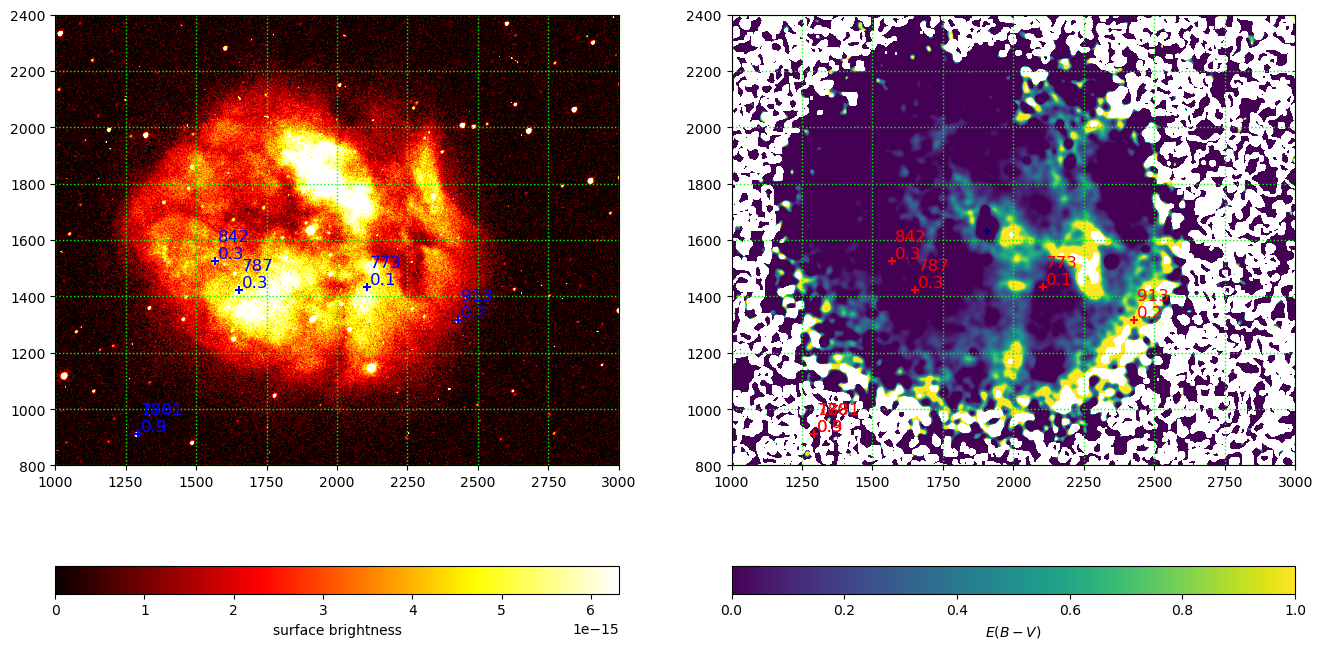

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 13))
axes = axes.flatten()

# Plot Hα flux
im0 = axes[0].imshow(image['Ha'],origin='lower',clim=[0, np.quantile(image['Ha'], 0.99)], cmap='hot')
fig.colorbar(im0, ax=axes[0], location='bottom', fraction=0.0375, pad=0.1, label='surface brightness')

# Plot E(B-V) map

EBmV = 1.97 * np.log10(smoothed_image_Ha_gauss/smoothed_image_Hb_gauss /2.86)

im1 = axes[1].imshow(EBmV, clim = [0,1], origin='lower', cmap='viridis') 
fig.colorbar(im3, ax=axes[1], location='bottom', fraction=0.0375, pad=0.1,label='$E(B-V)$')

c = ['blue','red']
center_x, center_y = radec_to_xy(328.370134,47.266320) 
plt.scatter(center_x, center_y, marker='+', c='navy')
for j in range(2):
    d = stars_behind_nebula[0]['distance']
    EBmV_Calzetti = 0.86
    axes[j].text(x+10,y+10,f"{d:.0f}\n{EBmV_Calzetti:.1f}",c=c[j],fontsize=12)

for j in range(2):
    for star in stars_behind_nebula[1:]:
        ra = star['ra']
        dec = star['dec']
        x, y = radec_to_xy(ra,dec)
        axes[j].scatter(x,y,marker='+',c=c[j])
        d = star['distance']
        EBmV_Calzetti = star['EBmV_fit Calzetti']    
        EBmV_Cardelli = star['EBmV_fit Cardelli']   
        axes[j].text(x+10,y+10,f"{d:.0f}\n{EBmV_Calzetti:.1f}",c=c[j],fontsize=12)
    
    axes[j].grid(visible=True, linestyle=':', linewidth=1,c='lime')
    axes[j].set_xlim(1000,3000)
    axes[j].set_ylim(800,2400)

plt.show()

# Hypotesis 1: optically thin, uniform sphere

In [11]:

# Central star is BD+46 3474 ( 	21 53 28.849152 	+47 15 59.78412   or    328.370205 	47.266607   J2000 ) 
# https://simbad.u-strasbg.fr/simbad/sim-coo?&Coord=328.375681513405d47.263674788998d&CooFrame=FK5&Radius=2&Radius.unit=arcmin
center_x, center_y = radec_to_xy(328.370134,47.266320) 

# Define the inner and outer radii for the circular annuli such that each annulus contains the same number of pixels
num_annuli = 40
N = 50000
R_int_pixel = [0.1]
R_ext_pixel = []

for i in range(num_annuli):
    r_ext = np.sqrt(N/np.pi + R_int_pixel[-1]**2)  # Use the previous outer radius to define the next outer radius
    R_ext_pixel.append(r_ext)
    R_int_pixel.append(r_ext)

# Generate the list of annuli radii as tuples of inner and outer radii (PIXEL SPACE)
annuli_radii = [(R_int_pixel[i], R_ext_pixel[i]) for i in range(num_annuli)]  

# Average surface brightness in each annulus
from photutils.aperture import CircularAnnulus, aperture_photometry

average_surface_brightness_Ha = []
sigma_surface_brightness_Ha = []

average_surface_brightness_Hb = []
sigma_surface_brightness_Hb = []

balmer_decrement = []
balmer_decrement_error = []

for inner_r, outer_r in annuli_radii:

    annulus = CircularAnnulus((center_x, center_y), r_in=inner_r, r_out=outer_r)

    # Ha
    phot = aperture_photometry(masked_Ha, annulus, error = np.full(masked_Ha.shape, sigma['Ha']))
    I_Ha = phot['aperture_sum'][0]
    Ha_err = phot['aperture_sum_err'][0]               # = sqrt(N) * sigma
    average_surface_brightness_Ha.append(I_Ha / N)
    sigma_surface_brightness_Ha.append(Ha_err / N)

    # Hb
    phot = aperture_photometry(masked_Hb, annulus, error = np.full(masked_Hb.shape, sigma['Hb']))
    I_Hb = phot['aperture_sum'][0]
    Hb_err = phot['aperture_sum_err'][0]
    average_surface_brightness_Hb.append(I_Hb / N)
    sigma_surface_brightness_Hb.append(Hb_err / N)

    balmer_decrement.append(I_Ha/I_Hb)
    propagated_error = np.sqrt((Ha_err/I_Hb)**2 + (I_Ha/I_Hb**2 * Hb_err )**2)
    balmer_decrement_error.append(propagated_error)


0.28105750648144
4.188476928485025


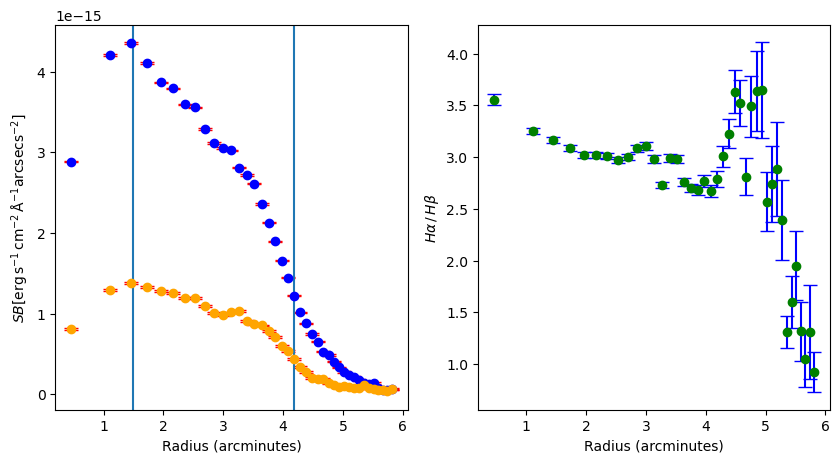

In [12]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

angular_size_pixel_TOBI_arcmin = 0.44 / 60 # arcmin per pixel
theta_r = np.array([(inner_r + outer_r) / 2 for inner_r, outer_r in annuli_radii]) * angular_size_pixel_TOBI_arcmin

ax[0].errorbar(theta_r, average_surface_brightness_Ha, yerr=sigma_surface_brightness_Ha, fmt='o', color='blue', 
             ecolor='red', capsize=5, linestyle='None')

ax[0].errorbar(theta_r, average_surface_brightness_Hb, yerr=sigma_surface_brightness_Hb, fmt='o', color='orange', 
             ecolor='red', capsize=5, linestyle='None')

ax[1].errorbar(theta_r, balmer_decrement, yerr=balmer_decrement_error, fmt='o', color='green', 
             ecolor='blue', capsize=5, linestyle='None')

ax[0].set_xlabel('Radius (arcminutes)')
ax[0].set_ylabel('$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$')

ax[1].set_xlabel('Radius (arcminutes)')
ax[1].set_ylabel('$H\\alpha\,/\,H\\beta$')

ax[0].axvline(x = 1.5)

# the cloud radius is defined as the place where the surface brightness drops of a factor 95%

print(average_surface_brightness_Ha[20]/max(average_surface_brightness_Ha))
print(theta_r[20])
ax[0].axvline(x = theta_r[20])

plt.show()

In [13]:
# Many radial profiles



In [17]:
# MODELS

# phyisical constants
wavelength_Ha = 656.281e-7    # Ha line (cm)
h = 6.62607015e-27            # Planck's constant (erg·s)
c = 3.0e10                    # Speed of light (cm/s)

parsec = 3.086e18             # cm

T = 6500                                # electron temperature [K]
alpha_B = 2.59e-13 * (T / 1e4)**(-0.7)  # case B total recombination coefficient (cm^3/s) from Hummer & Storey (1987)
alpha_B_Ha = alpha_B * 1                # Recombination coefficient for Halpha ??

from scipy.integrate import quad
def SB_model(r, j, csi, sigma_dust, R_cloud, R_inner_void):
    
    s = np.where(r < R_inner_void, 
                 2 * R_cloud * np.sqrt(1 - (r / R_cloud) ** 2) - 2 * R_inner_void * np.sqrt(1 - (r / R_inner_void) ** 2),
                 2 * R_cloud * np.sqrt(1 - (r / R_cloud) ** 2))

    return j/(csi * sigma_dust * n_H) * (1-np.exp(-csi * sigma_dust * n_H * s))


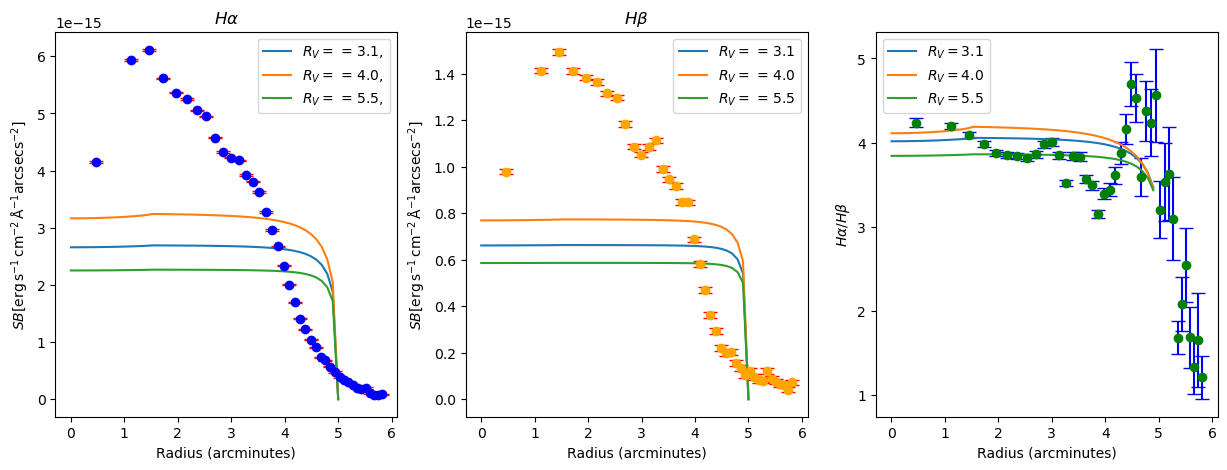

In [36]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

## PLOT MODELS

# cloud parameters
distance = 714 * parsec
n_H = 1e2                    # Hydrogen number density typical for HII region [cm^-3]
x = 0.1                      # ionized fraction
csi = 20                      # dust parameter

R_inner_void = 1.5 / 3437.75 * distance  # Radius of the innermost depleted region
R_cloud = 5 / 3437.75 * distance         # Stromgren radius

# emissivity
j_Ha = x**2 * n_H**2 * alpha_B_Ha * h*c / wavelength_Ha / 206265**2
j_Hb = j_Ha / 2.86

r_grid = np.linspace(0,R_cloud)
theta_r_grid = r_grid / distance * 3437.75

for rv in R_V:

    sigma_dust_H_Ha = dust_extinction[rv]['extinction_H_curve'](wavelength_Ha*1e4)
    sigma_dust_H_Hb = dust_extinction[rv]['extinction_H_curve'](wavelength_Hb*1e4)
    
    ax[0].plot(theta_r_grid, SB_model(r_grid, j_Ha, csi,sigma_dust_H_Ha, R_cloud, R_inner_void),label=rf"$R_V = $ = {rv}, ")
    ax[0].legend()

    ax[1].plot(theta_r_grid, SB_model(r_grid, j_Hb, csi,sigma_dust_H_Hb, R_cloud, R_inner_void),label=rf"$R_V = $ = {rv}")
    ax[1].legend()
    
    ax[2].plot(theta_r_grid, SB_model(r_grid, j_Ha, csi,sigma_dust_H_Ha, R_cloud, R_inner_void)/SB_model(r_grid, j_Hb, csi,sigma_dust_H_Hb, R_cloud, R_inner_void),
               label=f"$R_V = {rv}$") 
    ax[2].legend()

## PLOT DATA

angular_size_pixel_TOBI_arcmin = 0.44 / 60 # arcmin per pixel
theta_r = np.array([(inner_r + outer_r) / 2 for inner_r, outer_r in annuli_radii]) * angular_size_pixel_TOBI_arcmin

ax[0].errorbar(theta_r, average_surface_brightness_Ha, yerr=sigma_surface_brightness_Ha, fmt='o', color='blue', 
             ecolor='red', capsize=5, linestyle='None')

ax[1].errorbar(theta_r, average_surface_brightness_Hb, yerr=sigma_surface_brightness_Hb, fmt='o', color='orange', 
             ecolor='red', capsize=5, linestyle='None')

ax[2].errorbar(theta_r, balmer_decrement, yerr=balmer_decrement_error, fmt='o', color='green', 
             ecolor='blue', capsize=5, linestyle='None')

for i in range(3):
    ax[i].set_xlabel('Radius (arcminutes)')

ax[0].set_title('$H\\alpha$')
ax[0].set_ylabel('$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$')
ax[1].set_title('$H\\beta$')
ax[1].set_ylabel('$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$')

ax[2].set_ylabel('$H\\alpha/H\\beta$')


plt.show()


Filename: data/p387Dust.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   (82, 82)   float64   


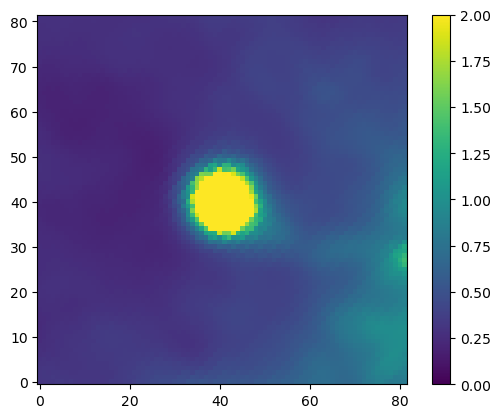

In [190]:
with fits.open("data/p387Dust.fits") as hdul:
    hdul.info()
    #if len(hdul) > 1:
    #    table_hdu = hdul[1]  
    dust_map_nasa = hdul[0].data

        #if table_hdu.data.ndim == 1:
        #    table = np.stack(table_hdu.data)

        #for row in table:
        #    stars_astrometry.append({'ra': row[0], 'dec': row[1], 'x': row[2], 'y': row[3]})
#clim=[0, np.quantile(dust_map_nasa, 0.99)]
plt.imshow(dust_map_nasa, clim=[0,2],cmap='viridis', origin='lower')
plt.colorbar()

In [ ]:
# central star 

In [ ]:
XP_SAMPLED-Gaia DR3 1974546106933956608.fits

In [ ]:
The radiative transfer equation for optically thin sphere (with no diffusion involved) tells:

$$dI_\lambda = -I_\lambda\,\alpha_\lambda ds + j_\lambda ds$$

where the specific emissivity is a function of the ionized fraction (that we will assume 1 inside all nebula), the proton number density and the temperature:

$$j_\lambda = x^2 \,n_H^2 \alpha_\lambda(T)\frac{hc}{\lambda}$$

$\alpha_\lambda(T)$ is part of the effective recombination coefficient, and for $T\sim 10^4 \ \text{K}$, typical for an HII region, is $10^{-13} \mathrm{cm^3 \ s^{-1}}$ for $H\alpha$ line. The emissivity $j$ is measured in $\mathrm{erg \ s^{-1} cm^{-2} \ sterad^{-1}}$. 
Moreover we need to convert sterad to $\text{arcsec}^2$: $1 \ \text{sterad} = (206265 \text{arcsec})^2$.

For an optically thin spherical cloud (case B recombination: the cloud is optically thick only for Lyman continuum photons, but optically thin for all other transitions, like H$\alpha$ or H$\beta$):

$$SB(r) = j \, ds = 2 \int_{\arcsin(r/R_\text{cloud})}^{\pi/2} j \, R_\text{cloud}\sin(\theta)d\theta = 2 j\, R_\text{cloud} \sqrt{1-(\tfrac{r}{R_\text{cloud}})^2}$$

where $r = R_{cloud} sin(\theta)$ is the projected radius in the sky. 

However, if we consider dust absorption the full radiative transfer equation must be considered:

$$I_\lambda(\tau_\lambda) = I_{0,\lambda}e^{-\tau_\lambda} + \int_0^{\tau_\nu} e^{-(\tau_\nu-\tau_\nu')}S_\lambda(\tau_\lambda')d\tau'_\lambda$$

where the dust optical depth is:

$$\tau_\lambda = \int \alpha_\lambda ds = \int f\, n_\text{dust}\sigma_\lambda ds = \sigma_\lambda \frac{n_\text{dust}}{n_H} \int f\,n_Hds = \sigma_{\lambda,H} \, f\,n_H \, s = \sigma_{\lambda,H}\, N_H$$

where $\sigma_{\lambda,H}$ is the cross section per unit hydrogen atom for the Milky Way.


**Radiative transfer for a spherical emitting and self-absorbing cloud:**

We introduce a parameter $\xi$ that accounts for over abundance in the nebula of dust with respect to the standard Milky Way conditions:

$$\tau_\lambda = \xi \, \sigma_{\lambda,H}\, N_H$$

$$I_\lambda(s) = \xi\,\sigma_{\lambda,H} \, n_H \int_0^{s} e^{-\xi\,\sigma_{\lambda,H}\,n_H\,(s-s')} \frac{j_\lambda}{\xi\,\sigma_{\lambda,H}n_H} ds' = \frac{j_\lambda}{\xi\,\sigma_{\lambda,H}\,n_H}\left(1-e^{-\xi\,\sigma_{\lambda,H}\,n_H\, s}    \right)$$


**Balmer decrements**

Dust absorption depends strongly on the wavelength. 

$$\frac{I(H\alpha)}{I(H\beta)}(s) = \frac{j_\alpha}{j_\beta} \cdot \frac{\sigma_{\beta,H}}{\sigma_{\alpha,H}} \cdot \frac{ \left(1 - e^{-\xi\,\sigma_{\alpha,H}\,n_H\,s}\right)}{\left(1 - e^{-\xi\,\sigma_{\beta,H} \, n_H \, s}\right)}$$

The ratio of the emissivities depends only on the temperature, that we can assume $T\sim 10^4$ K. It is 2.86.

In [ ]:
# Model 2. Optically thick? 

# Central star is BD+46 3474 (328.370134,47.266320) 
# https://simbad.u-strasbg.fr/simbad/sim-coo?&Coord=328.369092937714d47.259304681846d&CooFrame=FK5&Radius=2&Radius.unit=arcmin
#center_x, center_y = radec_to_xy(328.370134,47.266320) 





In [ ]:
# Does the central star saturates ? 

fig, ax = plt.subplots(1,2,figsize=(8,4))

from matplotlib.colors import LogNorm
im = ax[0].imshow(filtered_image, cmap=filter_cmap['Ha'],norm=LogNorm(vmin=1e-18, vmax=np.quantile(image['Ha'], 0.99999)),origin='lower')
plt.colorbar(im, ax = ax[0], location='bottom', fraction=0.0375, pad=0.1, label="$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")

center_x, center_y = radec_to_xy(328.370134,47.266320) 
l = 30
ax[0].set_xlim(center_x-l,center_x+l)
ax[0].set_ylim(center_y-l,center_y+l)

rectangle = filtered_image[int(center_y-l):int(center_y+l), int(center_x-l):int(center_x+l)]
y, x = np.mgrid[:rectangle.shape[0], :rectangle.shape[1]]
g_init = models.Gaussian2D(amplitude=rectangle.max(), x_mean=l, y_mean=l, x_stddev=5, y_stddev=5)
fit = fitting.LevMarLSQFitter()
g_fit = fit(g_init, x, y, rectangle)
            
refined_x = center_x - l + g_fit.x_mean.value
refined_y = center_y - l + g_fit.y_mean.value

sigma_x, sigma_y = g_fit.x_stddev.value, g_fit.y_stddev.value
fwhm_x = 2.355 * sigma_x
fwhm_y = 2.355 * sigma_y
fwhm = (fwhm_x + fwhm_y) / 2

# For 1,2,3 fwhm
from matplotlib.patches import Circle
for i in range(1,4):
    circle = Circle((center_x, center_y), radius=i*fwhm, fill=False, linewidth=3, linestyle='-')  #
    ax[0].add_patch(circle)

# Create custom legend handles (for circles)
#handles = [Line2D([0], [0], color=colors[i], lw=3, linestyle = '-',label=f"${sigma_dust_arr[i]:.1e}$  ; {tau_arr[i]:.1f} ; {r/parsec:.2f}") for i, r in enumerate(stromgen_radius)]


#Check if the computed PSF and the empirical PSF agree 
# Empirical PSF

center_x, center_y = radec_to_xy(328.370134,47.266320) 
r = np.arange(0.1,30.1,1)
annuli_radii = [(r[i], r[i+1]) for i in range(len(r) - 1)]

# Average surface brightness in each annulus to get the PSF
from photutils.aperture import CircularAnnulus, aperture_photometry

surface_brightness_central_star = []
for inner_r, outer_r in annuli_radii:

    annulus = CircularAnnulus((center_x, center_y), r_in=inner_r, r_out=outer_r)
    
    phot = aperture_photometry(filtered_image, annulus, error = np.full(masked_image.shape, sigma[f]))
    annulus_flux = phot['aperture_sum'][0]
    annulus_flux_err = phot['aperture_sum_err'][0]
    area_annulus = np.pi * (outer_r**2 - inner_r**2)
    surface_brightness_central_star.append(annulus_flux / area_annulus)
    #sigma_surface_brightness.append(annulus_flux_err / area_annulus)

ax[1].scatter(r[:-1], surface_brightness_central_star/max(surface_brightness_central_star))

from scipy.stats import norm
x = np.linspace(0,30)
gaus_pdf = norm.pdf(x,loc=0, scale=g_fit.x_stddev.value)
ax[1].plot(x,gaus_pdf/max(gaus_pdf),c='red')

plt.show()